In [1]:
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np
import time
K = keras.backend
import pandas as pd
import math
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn 


tf.random.set_seed(42)
np.random.seed(42)
random_state=42

In [2]:
save_path = 'save_path'
os.chdir(save_path)

X_train_omics_unlabelled = pd.read_csv("X_train_omics_unlabelled.csv",index_col=0)
X_train_omics_labelled = pd.read_csv("X_train_omics_labelled.csv",index_col=0)
X_test_omics= pd.read_csv("X_test_omics.csv",index_col=0)
X_valid_omics= pd.read_csv("X_valid_omics.csv",index_col=0)
features = np.load("feature_selection.npy",allow_pickle=True)

train_set_labelled_y= pd.read_csv("train_set_labelled_y.csv",index_col=0)
test_set_labelled_y= pd.read_csv("test_set_labelled_y.csv",index_col=0)
valid_set_labelled_y= pd.read_csv("valid_set_labelled_y.csv",index_col=0)

X_train_omics_unlabelled = X_train_omics_unlabelled[features]
X_train_omics_labelled = X_train_omics_labelled[features]
X_test_omics = X_test_omics[features]
X_valid_omics = X_valid_omics[features]


#bin y 
from sklearn.preprocessing import KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=10,encode="onehot-dense",strategy="uniform")
train_set_labelled_y = binner.fit_transform(train_set_labelled_y)
valid_set_labelled_y = binner.transform(valid_set_labelled_y)
test_set_labelled_y=binner.transform(test_set_labelled_y)



In [20]:
input_shape = X_train_omics_labelled.shape[1]

# Load best model (MMD) # 

## Custom parts ##

In [21]:
class Sampling(keras.layers.Layer):
    """reparameterization trick"""
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean   
    
    
class y_dist(keras.layers.Layer):
    """
    Custom layer that is used to learn the parameters, p, of the distribution over y.
    
    Outputs a loss and p. The loss is used for training. The loss is the categorical cross entropy loss between 
    p and every y sample. The mean of this is then taken to provide a per batch loss. 
    
    Shapes are configured for a 10D y. Change if you want to use different number of categories.
    
    """
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
    def build(self,batch_input_shape):
        self.q = self.add_weight(name="q",shape=[1,9],initializer="uniform",trainable=True)
        super().build(batch_input_shape)
    
    def call(self,X):
        concatenated = tf.concat([self.q,tf.constant(np.array(0.0).reshape(1,-1),dtype="float32")],axis=-1)
        p = K.exp(concatenated)
        p = tf.math.divide(p,K.sum(p))
        loss = keras.losses.categorical_crossentropy(X,p)
        loss = tf.reduce_mean(loss)
        return loss,p 
    
    def compute_output_shape(self,batch_input_shape):
        return tf.TensorShape(10)
    

## Load model ##

In [22]:
save_path = 'save_model_path'
os.chdir(save_model_path)

variational_encoder = keras.models.load_model("variational_encoder.h5", custom_objects={
   "Sampling": Sampling
})
variational_decoder = keras.models.load_model("variational_decoder.h5")
classifier = keras.models.load_model("classifier.h5")     
y_distribution = keras.models.load_model("y_distribution.h5", custom_objects={
   "y_dist": y_dist
})    

#for the loaded MMD model. Hyperparameters can be found in the relevant notebook.
codings_size=119

In [23]:
save_figure_path= 'save_figure_path'
os.chdir(save_figure_path)


# TSNE Visualisations #

In [25]:
tsne = TSNE(random_state=42)

In [26]:
########### preparation of data #################

######## training data #############

x_val_len = len(X_train_omics_labelled)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_train_synthetic = variational_decoder([z,train_set_labelled_y])
train_x = np.concatenate((X_train_omics_labelled.to_numpy(),x_train_synthetic))

######## val data ##############
x_val_len = len(X_valid_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_valid_synthetic = variational_decoder([z,valid_set_labelled_y])
valid_x = np.concatenate((X_valid_omics.to_numpy(),x_valid_synthetic))

######### test data #########
x_val_len = len(X_test_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_test_synthetic = variational_decoder([z,test_set_labelled_y])
test_x = np.concatenate((X_test_omics.to_numpy(),x_test_synthetic))

In [27]:
omics_tsne = tsne.fit_transform(np.vstack([train_x,valid_x,test_x]))

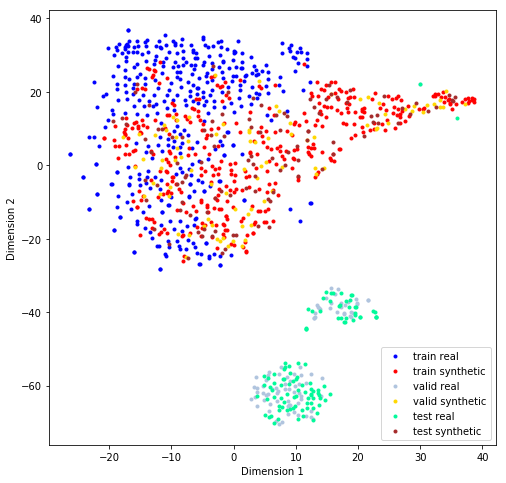

In [38]:
fig= plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

ax1.scatter(x=omics_tsne[0:383,0],y=omics_tsne[0:383,1],c="blue",marker=".",label="train real") #real train
ax1.scatter(x=omics_tsne[383:766,0],y=omics_tsne[383:766,1],c="red",marker=".",label="train synthetic") #fake train
ax1.scatter(x=omics_tsne[766:854,0],y=omics_tsne[766:854,1],c="lightsteelblue",marker=".",label="valid real") #real valid
ax1.scatter(x=omics_tsne[854:942,0],y=omics_tsne[854:942,1],c="gold",marker=".",label="valid synthetic") #fake valid
ax1.scatter(x=omics_tsne[942:1048,0],y=omics_tsne[942:1048,1],c="mediumspringgreen",marker=".",label="test real") #real test
ax1.scatter(x=omics_tsne[1048:,0],y=omics_tsne[1048:,1],c="brown",marker=".",label="test synthetic") #fake test
ax1.set(xlabel="Dimension 1",ylabel="Dimension 2")
#ax1.set_xlim([-70,70])
#ax1.set_ylim([-40,40])


plt.legend(loc="lower right")
plt.savefig("tsne.pdf")
plt.savefig("tsne.png")
plt.show()



# Histograms #

## All data ##

### methylation intensities ###

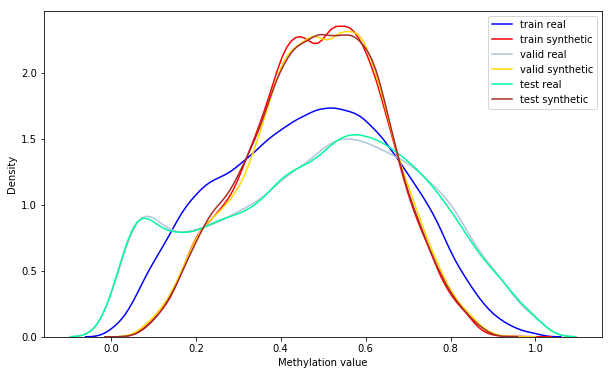

In [39]:
fig= plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)


seaborn.distplot(X_train_omics_labelled.to_numpy(),color="blue",hist=False,label = "train real")
seaborn.distplot(x_train_synthetic,color="red",hist=False,label="train synthetic")
seaborn.distplot(X_valid_omics.to_numpy(),color="lightsteelblue",hist=False,label="valid real")
seaborn.distplot(x_valid_synthetic,color="gold",hist=False,label="valid synthetic")
seaborn.distplot(X_test_omics.to_numpy(),color="mediumspringgreen",hist=False,label="test real")
seaborn.distplot(x_test_synthetic,color="brown",hist=False,label="test synthetic")

ax1.set(xlabel="Methylation value",ylabel="Density")

plt.legend(loc="upper right")

plt.savefig("dnam_hist.pdf")
plt.savefig("dnam_hist.png")

### methylation ranges ###

In [40]:
def methylation_ranges(numpy_array,top_percentile=95,bottom_percentile=5):
    return np.percentile(numpy_array,top_percentile,axis=0) - np.percentile(numpy_array,bottom_percentile,axis=0)

In [41]:
train_real = methylation_ranges(X_train_omics_labelled)
train_synthetic = methylation_ranges(x_train_synthetic)
valid_real = methylation_ranges(X_valid_omics)
valid_synthetic = methylation_ranges(x_valid_synthetic)
test_real = methylation_ranges(X_test_omics)
test_synthetic = methylation_ranges(x_test_synthetic)


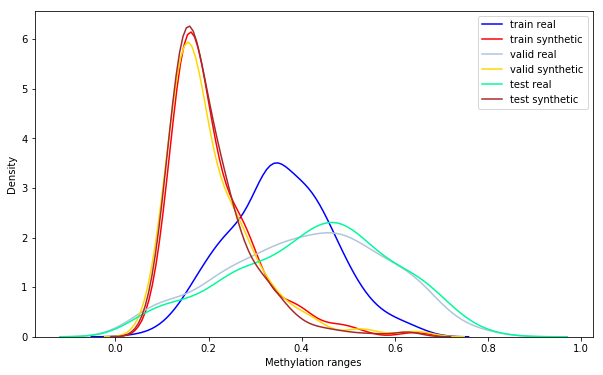

In [42]:
fig= plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)


seaborn.distplot(train_real,color="blue",hist=False,label = "train real")
seaborn.distplot(train_synthetic,color="red",hist=False,label="train synthetic")
seaborn.distplot(valid_real,color="lightsteelblue",hist=False,label="valid real")
seaborn.distplot(valid_synthetic,color="gold",hist=False,label="valid synthetic")
seaborn.distplot(test_real,color="mediumspringgreen",hist=False,label="test real")
seaborn.distplot(test_synthetic,color="brown",hist=False,label="test synthetic")

ax1.set(xlabel="Methylation ranges",ylabel="Density")

plt.legend(loc="upper right")

plt.savefig("dnam_range_hist.pdf")
plt.savefig("dnam_range_hist.png")

### change in no2 ###

#### Looking at max change in NO2 ####

In [52]:
########### create synthetic data ##############

samples = 3000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
y_max = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]).reshape(1,10) 
y_max = np.repeat(y_max,repeats=samples,axis=0)
synthetic_ymax = variational_decoder([z,y_max])

y_min = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10)
y_min = np.repeat(y_min,repeats=samples,axis=0)
synthetic_ymin = variational_decoder([z,y_min])

difference = synthetic_ymax - synthetic_ymin

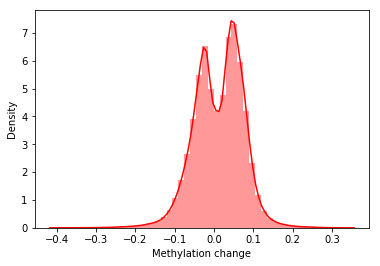

In [53]:
fig= plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
seaborn.distplot(difference,color="red")
ax1.set(xlabel="Methylation change",ylabel="Density")
plt.savefig("max_change_no2.pdf")
plt.savefig("max_change_no2.png")

In [47]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(np.mean(difference,axis=0))].columns
mean_difference = np.sort(np.mean(difference,axis=0))
column_argument = np.argsort(np.mean(difference,axis=0))
d = {"CpG site": cpg_sites, "mean methylation difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)


In [48]:
#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,mean methylation difference
CpG site,,
cg22237459,77,-0.101181
cg05787193,126,-0.100006
cg14428027,63,-0.098609
cg08347183,226,-0.095936
cg11322251,117,-0.090568


In [49]:
#top 5 CpG sites that become more positive on increasing no2
dataframe.iloc[-5:]

,column,mean methylation difference
CpG site,,
cg09169516,102,0.102757
cg24408776,144,0.105299
cg15604398,54,0.107377
cg26532499,257,0.108689
cg10783050,224,0.118849


#### Looking at changing NO2 from min to 2nd to max category ####

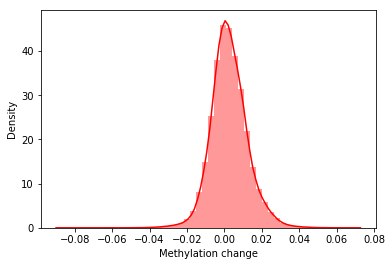

In [54]:
########### create synthetic data ##############

samples = 3000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
y_max = np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]).reshape(1,10) 
y_max = np.repeat(y_max,repeats=samples,axis=0)
synthetic_ymax = variational_decoder([z,y_max])

y_min = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10)
y_min = np.repeat(y_min,repeats=samples,axis=0)
synthetic_ymin = variational_decoder([z,y_min])

difference = synthetic_ymax - synthetic_ymin

fig= plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
seaborn.distplot(difference,color="red")
ax1.set(xlabel="Methylation change",ylabel="Density")
plt.savefig("min2secondmax_change_no2.pdf")
plt.savefig("min2secondmax_change_no2.png")

In [55]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(np.mean(difference,axis=0))].columns
mean_difference = np.sort(np.mean(difference,axis=0))
column_argument = np.argsort(np.mean(difference,axis=0))
d = {"CpG site": cpg_sites, "mean methylation difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)

#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,mean methylation difference
CpG site,,
cg03847896,213,-0.025527
cg24143305,252,-0.018971
cg03226218,215,-0.014849
cg23259381,233,-0.012607
cg08822227,55,-0.012511


In [56]:
#top 5 CpG sites that become more positive on increasing no2
dataframe.iloc[-5:]

,column,mean methylation difference
CpG site,,
cg13974313,160,0.023647
cg14473643,250,0.023679
cg01357671,271,0.024038
cg15684811,281,0.030206
cg13469425,65,0.034689


Completely different CpG sites show the max changes for the above two scenarios.

Maybe because the training set only had 1 example of a y in the max level, so didn't see a lot of training data for that max value. 


In [460]:
len(train_set_labelled_y[train_set_labelled_y[:,9]==1])

1

#### varying no2 from 4th to 6th bin - as these have the most number of training points ####

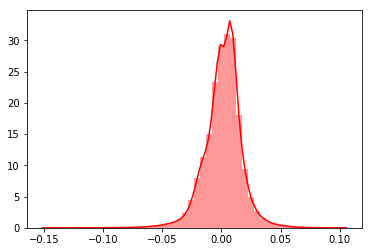

In [454]:
########### create synthetic data ##############

samples = 3000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
y_max = np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]).reshape(1,10) 
y_max = np.repeat(y_max,repeats=samples,axis=0)
synthetic_ymax = variational_decoder([z,y_max])

y_min = np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]).reshape(1,10)
y_min = np.repeat(y_min,repeats=samples,axis=0)
synthetic_ymin = variational_decoder([z,y_min])

difference = synthetic_ymax - synthetic_ymin

seaborn.distplot(difference,color="red")

In [455]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(np.mean(difference,axis=0))].columns
mean_difference = np.sort(np.mean(difference,axis=0))
column_argument = np.argsort(np.mean(difference,axis=0))
d = {"CpG site": cpg_sites, "mean methylation difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)

#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,mean methylation difference
CpG site,,
cg08347183,226,-0.032274
cg15684811,281,-0.025905
cg15096815,81,-0.025699
cg22234827,190,-0.024296
cg05264446,50,-0.023831


In [461]:
#top 5 CpG sites that become more positive on increasing no2
dataframe.iloc[-5:]

,column,mean methylation difference
CpG site,,
cg00712106,194,0.024608
cg10783050,224,0.026253
cg24408776,144,0.033089
cg24143305,252,0.033889
cg13469425,65,0.039118


#### all cpg sites ####

In [66]:
#plot showing how cpgs changes as no2 is increased

samples = 3000

z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)

y9 = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]).reshape(1,10) 
y9 = np.repeat(y9,repeats=samples,axis=0)
synthetic_y9_mean = np.mean(variational_decoder([z,y9]),axis=0)

y8 = np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]).reshape(1,10) 
y8 = np.repeat(y8,repeats=samples,axis=0)
synthetic_y8_mean = np.mean(variational_decoder([z,y8]),axis=0)

y7 = np.array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]).reshape(1,10) 
y7 = np.repeat(y7,repeats=samples,axis=0)
synthetic_y7_mean = np.mean(variational_decoder([z,y7]),axis=0)

y6 = np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]).reshape(1,10) 
y6 = np.repeat(y6,repeats=samples,axis=0)
synthetic_y6_mean = np.mean(variational_decoder([z,y6]),axis=0)

y5 = np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]).reshape(1,10) 
y5 = np.repeat(y5,repeats=samples,axis=0)
synthetic_y5_mean = np.mean(variational_decoder([z,y5]),axis=0)

y4 = np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]).reshape(1,10) 
y4 = np.repeat(y4,repeats=samples,axis=0)
synthetic_y4_mean = np.mean(variational_decoder([z,y4]),axis=0)

y3 = np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y3 = np.repeat(y3,repeats=samples,axis=0)
synthetic_y3_mean = np.mean(variational_decoder([z,y3]),axis=0)

y2 = np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y2 = np.repeat(y2,repeats=samples,axis=0)
synthetic_y2_mean = np.mean(variational_decoder([z,y2]),axis=0)

y1 = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y1 = np.repeat(y1,repeats=samples,axis=0)
synthetic_y1_mean = np.mean(variational_decoder([z,y1]),axis=0)

y0 = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y0 = np.repeat(y0,repeats=samples,axis=0)
synthetic_y0_mean = np.mean(variational_decoder([z,y0]),axis=0)

In [466]:
diff9 = synthetic_y9_mean - synthetic_y0_mean
diff8 = synthetic_y8_mean - synthetic_y0_mean
diff7 = synthetic_y7_mean - synthetic_y0_mean
diff6 = synthetic_y6_mean - synthetic_y0_mean
diff5 = synthetic_y5_mean - synthetic_y0_mean
diff4 = synthetic_y4_mean - synthetic_y0_mean
diff3 = synthetic_y3_mean - synthetic_y0_mean
diff2 = synthetic_y2_mean - synthetic_y0_mean
diff1 = synthetic_y1_mean - synthetic_y0_mean


In [416]:

y = np.array([diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9])

x = np.arange(1,10)

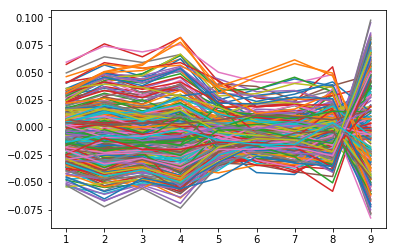

In [418]:
fig= plt.figure()
#ax1 = fig.add_subplot(111)
for i in range(290):
    plt.plot(x,y[:,i])


In [67]:
#absolute cpg values
y = np.array([synthetic_y0_mean,synthetic_y1_mean,synthetic_y2_mean,synthetic_y3_mean,synthetic_y4_mean,
             synthetic_y5_mean,synthetic_y6_mean,synthetic_y7_mean,synthetic_y8_mean,synthetic_y9_mean])

x = np.arange(0,10)

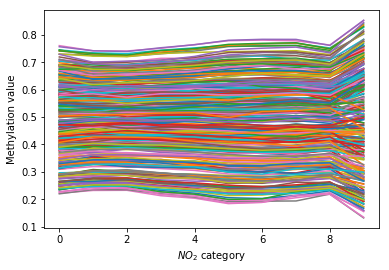

In [68]:
fig= plt.figure()
ax1 = fig.add_subplot(111)
for i in range(290):
    plt.plot(x,y[:,i])
ax1.set(xlabel="$NO_2$ category",ylabel="Methylation value")
plt.savefig("multi_site_absolute.pdf")
plt.savefig("mutli_site_absolute.png")

##### weighted avg of 1 bin increase in no2, weighted by number of training samples in each bin ####

In [504]:
diff9 = synthetic_y9_mean - synthetic_y8_mean
diff8 = synthetic_y8_mean - synthetic_y7_mean
diff7 = synthetic_y7_mean - synthetic_y6_mean
diff6 = synthetic_y6_mean - synthetic_y5_mean
diff5 = synthetic_y5_mean - synthetic_y4_mean
diff4 = synthetic_y4_mean - synthetic_y3_mean
diff3 = synthetic_y3_mean - synthetic_y2_mean
diff2 = synthetic_y2_mean - synthetic_y1_mean
diff1 = synthetic_y1_mean - synthetic_y0_mean

diff_list = [diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9]

In [505]:
bin_y0_points = len(train_set_labelled_y[train_set_labelled_y[:,0] == 1])
bin_y1_points = len(train_set_labelled_y[train_set_labelled_y[:,1] == 1])
bin_y2_points = len(train_set_labelled_y[train_set_labelled_y[:,2] == 1])
bin_y3_points = len(train_set_labelled_y[train_set_labelled_y[:,3] == 1])
bin_y4_points = len(train_set_labelled_y[train_set_labelled_y[:,4] == 1])
bin_y5_points = len(train_set_labelled_y[train_set_labelled_y[:,5] == 1])
bin_y6_points = len(train_set_labelled_y[train_set_labelled_y[:,6] == 1])
bin_y7_points = len(train_set_labelled_y[train_set_labelled_y[:,7] == 1])
bin_y8_points = len(train_set_labelled_y[train_set_labelled_y[:,8] == 1])
bin_y9_points = len(train_set_labelled_y[train_set_labelled_y[:,9] == 1])

bin_list = [bin_y0_points,bin_y1_points,bin_y2_points,bin_y3_points,bin_y4_points,bin_y5_points,bin_y6_points,bin_y7_points,
           bin_y8_points,bin_y9_points]

In [520]:
weighted_avg = 0
for index,i in enumerate(diff_list):
    weighted_avg += diff_list[index]*(bin_list[index] + bin_list[index+1])/2
weighted_avg = weighted_avg/sum(bin_list)
    

In [523]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(weighted_avg)].columns
difference = np.sort(weighted_avg)
column_argument = np.argsort(weighted_avg)
d = {"CpG site": cpg_sites, "weighted avg difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)

In [525]:
#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,weighted avg difference
CpG site,,
cg19448993,183,-0.032274
cg08347183,226,-0.025905
cg27393925,154,-0.025699
cg06197769,268,-0.024296
cg08797454,133,-0.023831


In [527]:
#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[-5:]

,column,weighted avg difference
CpG site,,
cg00712106,194,0.024608
cg09169516,102,0.026253
cg02327001,260,0.033089
cg10783050,224,0.033889
cg13469425,65,0.039118


#### single cpg ####

In [57]:
#plot showing how cpgs change as no2 is increased

samples = 500
cpg_index = 257
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)

y9 = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]).reshape(1,10) 
y9 = np.repeat(y9,repeats=samples,axis=0)
synthetic_y9_mean = variational_decoder([z,y9])[:,cpg_index]

y8 = np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]).reshape(1,10) 
y8 = np.repeat(y8,repeats=samples,axis=0)
synthetic_y8_mean = variational_decoder([z,y8])[:,cpg_index]

y7 = np.array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]).reshape(1,10) 
y7 = np.repeat(y7,repeats=samples,axis=0)
synthetic_y7_mean = variational_decoder([z,y7])[:,cpg_index]

y6 = np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]).reshape(1,10) 
y6 = np.repeat(y6,repeats=samples,axis=0)
synthetic_y6_mean = variational_decoder([z,y6])[:,cpg_index]

y5 = np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]).reshape(1,10) 
y5 = np.repeat(y5,repeats=samples,axis=0)
synthetic_y5_mean = variational_decoder([z,y5])[:,cpg_index]

y4 = np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]).reshape(1,10) 
y4 = np.repeat(y4,repeats=samples,axis=0)
synthetic_y4_mean = variational_decoder([z,y4])[:,cpg_index]

y3 = np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y3 = np.repeat(y3,repeats=samples,axis=0)
synthetic_y3_mean = variational_decoder([z,y3])[:,cpg_index]

y2 = np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y2 = np.repeat(y2,repeats=samples,axis=0)
synthetic_y2_mean = variational_decoder([z,y2])[:,cpg_index]

y1 = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y1 = np.repeat(y1,repeats=samples,axis=0)
synthetic_y1_mean = variational_decoder([z,y1])[:,cpg_index]

y0 = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,10) 
y0 = np.repeat(y0,repeats=samples,axis=0)
synthetic_y0_mean = variational_decoder([z,y0])[:,cpg_index]

In [58]:
#absolute cpg values
y = np.array([synthetic_y0_mean,synthetic_y1_mean,synthetic_y2_mean,synthetic_y3_mean,synthetic_y4_mean,
             synthetic_y5_mean,synthetic_y6_mean,synthetic_y7_mean,synthetic_y8_mean,synthetic_y9_mean])
y_mean = np.mean(y,axis=1)

x = np.arange(0,10)

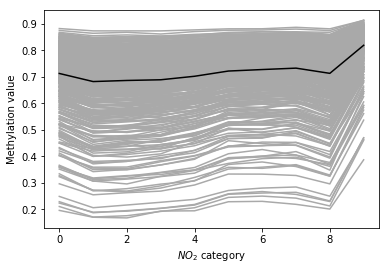

In [62]:
fig= plt.figure()
ax1 = fig.add_subplot(111)
for i in range(samples):
    plt.plot(x,y[:,i],color="darkgrey")
plt.plot(x,y_mean,color="black")
ax1.set(xlabel="$NO_2$ category",ylabel="Methylation value")
plt.savefig("single_sample_absolute.pdf")
plt.savefig("single_sample_absolute.png")

In [493]:
#plot showing differencial cpg values

In [63]:
diff9 = synthetic_y9_mean - synthetic_y0_mean
diff8 = synthetic_y8_mean - synthetic_y0_mean
diff7 = synthetic_y7_mean - synthetic_y0_mean
diff6 = synthetic_y6_mean - synthetic_y0_mean
diff5 = synthetic_y5_mean - synthetic_y0_mean
diff4 = synthetic_y4_mean - synthetic_y0_mean
diff3 = synthetic_y3_mean - synthetic_y0_mean
diff2 = synthetic_y2_mean - synthetic_y0_mean
diff1 = synthetic_y1_mean - synthetic_y0_mean

In [64]:

y = np.array([diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9])
y_mean = np.mean(y,axis=1)

x = np.arange(1,10)

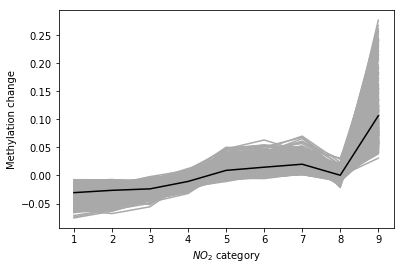

In [65]:
fig= plt.figure()
ax1 = fig.add_subplot(111)

for i in range(samples):
    plt.plot(x,y[:,i],color="darkgrey")
plt.plot(x,y_mean,color="black")

ax1.set(xlabel="$NO_2$ category",ylabel="Methylation change")
plt.savefig("single_sample_difference.pdf")
plt.savefig("single_sample_difference.png")

Massive spread when looking at difference from 0th to 9th bin. Probably due to only 1 training sample for 9th bin. Nevertheless, even the mean is noticeably higher. It is interesting how for the 0th to 9th bin, there is a prediction of positive change in beta value whereas for the others there is a negative change. 